# [LAB09] 지도학습 > 분류 > 08-다중분류(2)

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 라이브러리 기본 참조
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 분류모형 (대표모형 하나만 지정)
from sklearn.ensemble import RandomForestClassifier

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# 로지스틱 성능평가 함수
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")
from hs_eval_utils import *

### [2] 필요한 함수

- hs_describe()
- hs_category_describe()

### [3] 데이터 가져오기

In [2]:
origin = load_data("wine_dataset")
origin.head()

이 데이터는 이탈리아의 같은 지역에서 재배되었지만 서로 다른 세 가지 품종으로 만들어진 와인에 대한 화학 분석 결과입니다. 이 분석을 통해 세 가지 종류의 와인 각각에서 발견되는 13가지 성분의 함량을 측정했습니다. (출처: https://www.kaggle.com/datasets/tawfikelmetwally/wine-dataset)

변수명                        변수 유형          단위     의미                     해석 포인트
----------------------------  -----------------  -------  -----------------------  ---------------------------
class                         범주형 (종속변수)  -        와인 품종 (1,2,3)        다중분류 문제
Alcohol                       연속형             % (v/v)  알코올 도수              도수가 높을수록 바디감 강함
Malic acid                    연속형             g/L      말산 함량                산미와 관련
Ash                           연속형             g/L      무기질 총량              토양 영향 반영
Alcalinity of ash             연속형             mEq/L    회분의 알칼리도          무기물 성질 반영
Magnesium                     연속형             mg/L     마그네슘 농도            발효·효소 활동 관련
Total phenols                 연속형             g/L      총 페놀 함량             항산화 성분
Flavanoids                    연

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.230,1.710,2.430,15.600,127,2.800,3.060,0.280,2.290,5.640,1.040,3.920,1065
1,1,13.200,1.780,2.140,11.200,100,2.650,2.760,0.260,1.280,4.380,1.050,3.400,1050
2,1,13.160,2.360,2.670,18.600,101,2.800,3.240,0.300,2.810,5.680,1.030,3.170,1185
3,1,14.370,1.950,2.500,16.800,113,3.850,3.490,0.240,2.180,7.800,0.860,3.450,1480
4,1,13.240,2.590,2.870,21.000,118,2.800,2.690,0.390,1.820,4.320,1.040,2.930,735


### [4] 명목형에 대한 타입 변환

데이터 품질 확인을 위해서는 타입 변환이 수행되어야 한다.

In [3]:
df1 = origin.copy()
df1["class"] = df1["class"].astype("category")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   class                         178 non-null    category
 1   Alcohol                       178 non-null    float64 
 2   Malic acid                    178 non-null    float64 
 3   Ash                           178 non-null    float64 
 4   Alcalinity of ash             178 non-null    float64 
 5   Magnesium                     178 non-null    int64   
 6   Total phenols                 178 non-null    float64 
 7   Flavanoids                    178 non-null    float64 
 8   Nonflavanoid phenols          178 non-null    float64 
 9   Proanthocyanins               178 non-null    float64 
 10  Color intensity               178 non-null    float64 
 11  Hue                           178 non-null    float64 
 12  OD280/OD315 of diluted wines  178 non-null    floa

## #02. 데이터 품질 확인

### [1] 연속형 변수 품질 확인

In [4]:
desc = hs_describe(df1)
desc

,count,na_count,na_rate,mean,std,min,25%,50%,75%,max,iqr,up,down,outlier_count,outlier_rate,skew,dist,log_need
Alcohol,178.000,0,0.000,13.001,0.812,11.030,12.362,13.050,13.678,14.830,1.315,15.650,10.390,0,0.000,-0.051,거의 대칭,낮음
Malic acid,178.000,0,0.000,2.336,1.117,0.740,1.603,1.865,3.083,5.800,1.480,5.303,-0.617,3,1.685,1.040,중간 우측 꼬리,높음
Ash,178.000,0,0.000,2.367,0.274,1.360,2.210,2.360,2.558,3.230,0.348,3.079,1.689,3,1.685,-0.177,거의 대칭,낮음
Alcalinity of ash,178.000,0,0.000,19.495,3.340,10.600,17.200,19.500,21.500,30.000,4.300,27.950,10.750,4,2.247,0.213,거의 대칭,낮음
Magnesium,178.000,0,0.000,99.742,14.282,70.000,88.000,98.000,107.000,162.000,19.000,135.500,59.500,4,2.247,1.098,중간 우측 꼬리,높음
Total phenols,178.000,0,0.000,2.295,0.626,0.980,1.742,2.355,2.800,3.880,1.057,4.386,0.156,0,0.000,0.087,거의 대칭,낮음
Flavanoids,178.000,0,0.000,2.029,0.999,0.340,1.205,2.135,2.875,5.080,1.670,5.380,-1.300,0,0.000,0.025,거의 대칭,낮음
Nonflavanoid phenols,178.000,0,0.000,0.362,0.124,0.130,0.270,0.340,0.438,0.660,0.167,0.689,0.019,0,0.000,0.450,거의 대칭,낮음
Proanthocyanins,178.000,0,0.000,1.591,0.572,0.410,1.250,1.555,1.950,3.580,0.700,3.000,0.200,2,1.124,0.517,약간 우측 꼬리,중간
Color intensity,178.000,0,0.000,5.058,2.318,1.280,3.220,4.690,6.200,13.000,2.980,10.670,-1.250,4,2.247,0.869,약간 우측 꼬리,중간


> 결측치는 없으나, 약간의 이상치가 발견된다. 로그 변환을 통해 이상치를 완화할 수 있다.

### [2] 로그변환

In [5]:
fields = desc[desc["log_need"] != "낮음"].index.tolist()
fields

['Malic acid', 'Magnesium', 'Proanthocyanins', 'Color intensity', 'Proline ']

In [6]:
df2 = df1.copy()

for col in fields:
    df2[col] = np.log1p(df2[col])

df2.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.230,0.997,2.430,15.600,4.852,2.800,3.060,0.280,1.191,1.893,1.040,3.920,6.972
1,1,13.200,1.022,2.140,11.200,4.615,2.650,2.760,0.260,0.824,1.683,1.050,3.400,6.957
2,1,13.160,1.212,2.670,18.600,4.625,2.800,3.240,0.300,1.338,1.899,1.030,3.170,7.078
3,1,14.370,1.082,2.500,16.800,4.736,3.850,3.490,0.240,1.157,2.175,0.860,3.450,7.300
4,1,13.240,1.278,2.870,21.000,4.779,2.800,2.690,0.390,1.037,1.671,1.040,2.930,6.601


### [3] 명목형 변수(종속변수) 확인

In [7]:
a, b = hs_category_describe(df2)
display(a)
display(b)

,변수,범주,빈도,비율(%)
0,class,2,71,39.890
1,class,1,59,33.150
2,class,3,48,26.970


,최다_범주,최다_비율(%),최소_범주,최소_비율(%)
변수,,,,
class,2,39.890,3,26.970


> 클래스간 비율에 큰 차이를 보이지 않는다. 데이터 증강이 필요 없을것으로 보인다. 하지만 데이터 증강후 결과를 비교해 볼 필요는 있다.

## #03. 분류모형 적합

### [1] 데이터 분할

In [8]:
yname = "class"
x = df2.drop(columns=[yname])
y = df2[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((133, 13), (45, 13), (133,), (45,))

### [2] 학습모델 구성

실습 시간을 고려하여 RandomForest 모델에 대해서만 적용한다.

In [9]:
%%time

pipe = Pipeline([
    (
        "model",
        RandomForestClassifier(
            random_state=52,
            n_jobs=-1
        )
    ),
])

param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

CPU times: user 421 ms, sys: 163 ms, total: 584 ms
Wall time: 13.9 s


Pipeline(steps=[('model',
                 RandomForestClassifier(min_samples_leaf=5, n_estimators=500,
                                        n_jobs=-1, random_state=52))])

## #04. 성능평가

### [1] 다중분류 성능평가 함수 정의

In [10]:
def hs_cls_multi_scores(estimator, x_test, y_test):
    # -----------------------------
    # 입력값 정리
    # -----------------------------
    y_pred = estimator.predict(x_test)
    y_proba = estimator.predict_proba(x_test)
    classes = np.unique(y_test)

    # -----------------------------
    # 이항분류와 동일하게 사용가능한 지표
    # -----------------------------
    score_df = DataFrame(
        {
            "accuracy": [accuracy_score(y_test, y_pred)],
            "precision": [
                precision_score(y_test, y_pred, average="macro", zero_division=0)
            ],
            "recall": [recall_score(y_test, y_pred, average="macro", zero_division=0)],
            "f1": [f1_score(y_test, y_pred, average="macro", zero_division=0)],
        }
    )

    # -----------------------------
    # 다중분류 전용 지표 (OvR)
    # -----------------------------
    fpr_list = []
    tnr_list = []

    for i, cls in enumerate(classes):
        # 해당 클래스 vs 나머지
        y_true_binary = (y_test == cls).astype(int)
        y_pred_binary = (y_pred == cls).astype(int)

        cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])
        TN, FP, FN, TP = cm.ravel()

        fpr = FP / (FP + TN) if (FP + TN) > 0 else np.nan
        tnr = TN / (FP + TN) if (FP + TN) > 0 else np.nan

        fpr_list.append(fpr)
        tnr_list.append(tnr)

    score_df["FPR (macro)"] = np.nanmean(fpr_list)
    score_df["TNR (macro)"] = np.nanmean(tnr_list)

    # -----------------------------
    # 다중 AUC (OvR 방식)
    # -----------------------------
    score_df["AUC (macro, OvR)"] = roc_auc_score(
        y_test, y_proba, multi_class="ovr", average="macro"
    )

    # -----------------------------
    # 시각화
    # -----------------------------
    # y_test를 1차원 배열로 변환
    y_test_array = np.asarray(y_test).ravel()

    for i, cls in enumerate(classes):
        # 해당 클래스 vs 나머지
        y_true_binary = (y_test_array == cls).astype(int)
        y_score = y_proba[:, i]

        # ROC 계산
        fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
        auc_score = roc_auc_score(y_true_binary, y_score)

        # -----------------------------
        # 그래프 (클래스별 하나씩)
        # -----------------------------
        fig, ax = plt.subplots(1, 1, dpi=100, figsize=(480 / 100, 480 / 100))
        sb.lineplot(x=fpr, y=tpr)
        sb.lineplot(x=[0, 1], y=[0, 1], linestyle="--")
        ax.set_xlabel("False Positive Rate", fontsize=9)
        ax.set_ylabel("True Positive Rate", fontsize=9)
        ax.set_title(f"ROC Curve - Class {cls} (AUC={auc_score:.4f})", fontsize=10)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        plt.show()

    # -----------------------------
    # 결과리턴
    # -----------------------------
    return score_df

### [2] 성능평가

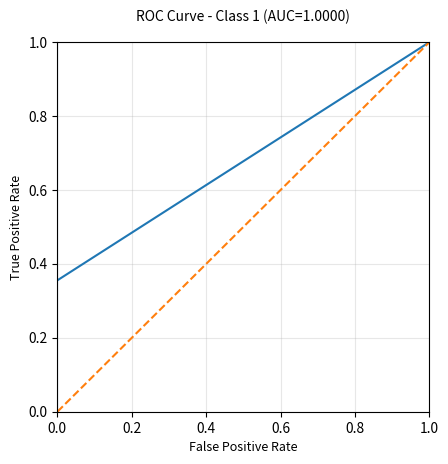

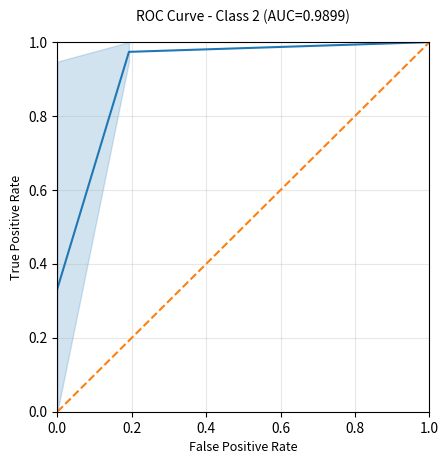

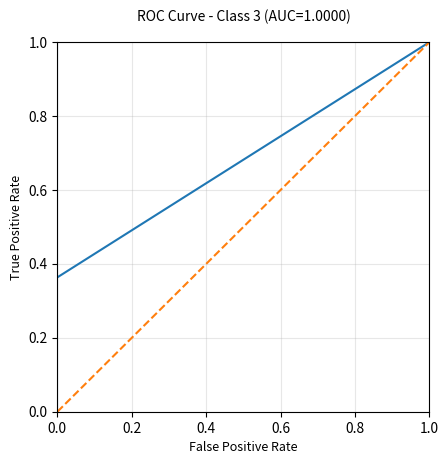

,accuracy,precision,recall,f1,FPR (macro),TNR (macro),"AUC (macro, OvR)"
0,0.978,0.972,0.982,0.976,0.010,0.990,0.997


In [11]:
score_df = hs_cls_multi_scores(estimator, x_test, y_test)
score_df

## #05. 데이터 증강 후 결과 비교

### [1] 데이터 증강 모델 적합

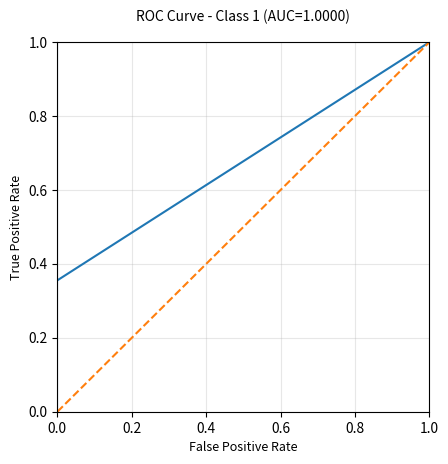

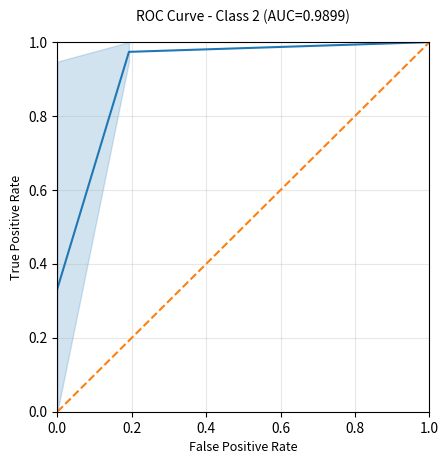

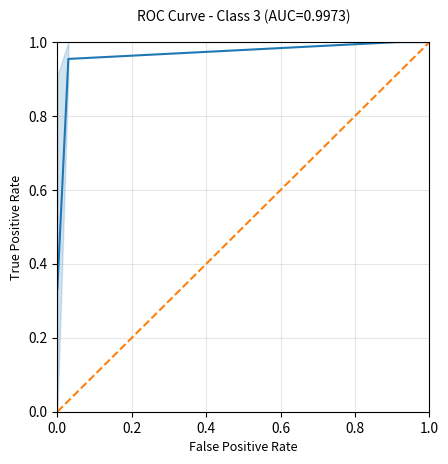

,accuracy,precision,recall,f1,FPR (macro),TNR (macro),"AUC (macro, OvR)"
기본,0.978,0.972,0.982,0.976,0.010,0.990,0.997
SMOTE,0.978,0.972,0.982,0.976,0.010,0.990,0.996


In [12]:
sm_pipe = imbPipeline(
    [
        ("scaler", StandardScaler()),
        ("sm", SMOTE(random_state=52, k_neighbors=5)),
        ("model", RandomForestClassifier(random_state=52, n_jobs=-1)),
    ]
)

sm_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

sm_gs = GridSearchCV(
    estimator=sm_pipe, param_grid=sm_param_grid, cv=5, scoring="accuracy", n_jobs=-1
)

sm_gs.fit(x_train, y_train)

rf_cls_estimator = sm_gs.best_estimator_

sm_score_df = hs_cls_multi_scores(rf_cls_estimator, x_test, y_test)

rdf = concat([score_df, sm_score_df], axis=0)
rdf.index = ["기본", "SMOTE"]
rdf

> 처음 예측했던바와 같이 데이터 불균형이 심하지 않은 데이터이므로 데이터 증강의 효과는 없다.

### 참고 - 로그변환을 수행하지 않은 경우의 결과

| | accuracy | precision | recall | f1 | FPR (macro) | TNR (macro) | AUC (macro, OvR) |
|---|---|---|---|---|---|---|---|
| 기본 | 0.978 | 0.972 | 0.982 | 0.976 | 0.010 | 0.990 | 0.997 |
| SMOTE | 0.978 | 0.972 | 0.982 | 0.976 | 0.010 | 0.990 | 0.997 |